# NRLMSIS-Persistence Baseline

This baseline is a very naive approach to the problem. Its main purpose is to guide participants through the different steps of preparing and testing a model, helping them understand the workflow required to make their own submissions.

In time series problems, the **persistence baseline** is often used to assess model performance. This approach simply takes the last observed value of the input and propagates it through the output, replicating the initial value as predictions for all future steps. It can be described as follows:

$$\hat{y}_{t+k} = y_t$$


\begin{aligned}
    &\hat{y}_{t+k} &:& \ \text{Predicted value at future time } t+k, \\
    &y_t           &:& \ \text{Observed value at the current time } t, \\
    &k             &:& \ \text{Forecast horizon (number of steps into the future)}.
\end{aligned}


For example, if \( y_t = 5 \), then for any \( k \):


$$\hat{y}_{t+1} = \hat{y}_{t+2} = \hat{y}_{t+3} = \dots = 5$$


Although this approach may seem overly simplistic, it is surprisingly effective in certain cases, to the point that beating it can be challenging. This is because, in time series prediction tasks, the closer the future time steps are to the present, the more similar their values tend to be due to local temporal dependencies. As a result, when there are no significant outliers, this method can deliver reasonably good performance.

In this particular case, as we need to propagate and do not know the values to propagate from the beginning, we will combine it with the NRLMSIS model to obtain predictions for the initial date along the propagated orbit at each time step. To achieve this, we will use the [`pymsis`](https://swxtrec.github.io/pymsis/) library. We will then propagate our results using the [custom propagator](https://github.com/ARCLab-MIT/STORM-AI-propagator/tree/main), which is provided as part of the development tools and makes use of the [`Orekit`](https://www.orekit.org/) library.

> *Note*: The `#|export` tags are used to export the code block to a script file called `atm.py` using the [`nbdev`](https://nbdev.fast.ai/) CLI tool. This allows us to use these classes in other scripts.

In [1]:
# | default_exp atm
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
from pymsis import msis
import dill

# Orekit imports
import orekit
from org.orekit.time import AbsoluteDate
from org.orekit.utils import PVCoordinates, Constants
from org.orekit.frames import Frame
from org.orekit.models.earth.atmosphere import PythonAtmosphere
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.frames import FramesFactory, Frame
from org.orekit.bodies import CelestialBodyFactory, OneAxisEllipsoid
from org.orekit.utils import IERSConventions
from org.orekit.time import TimeScalesFactory


# Initialize Orekit JVM
vm = orekit.initVM()
from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()

# Import the propagator script
from propagator import prop_orbit


Although the `pymsis` library does not require us to provide input data for the model, we will load the OMNI2 data available to participants as part of the challenge dataset. Here, we simply read the data file, retain the necessary columns, and perform basic preprocessing to fill missing values with the next available value.

In [2]:
# Load OMNI2 data directly
file_path = './dataset/test/OMNI2/omni2-wu001.csv'
omni2_data = pd.read_csv(file_path, usecols=['Timestamp', 'f10.7_index', 'ap_index_nT'])

# Process OMNI2 data immediately after loading
omni2_data['Timestamp'] = pd.to_datetime(omni2_data['Timestamp'])
omni2_data = omni2_data.ffill()
omni2_data

,Timestamp,ap_index_nT,f10.7_index
0,2013-11-29 00:00:00,4,125.0
1,2013-11-29 01:00:00,4,125.0
2,2013-11-29 02:00:00,4,125.0
3,2013-11-29 03:00:00,9,125.0
4,2013-11-29 04:00:00,9,125.0
...,...,...,...
1436,2014-01-27 20:00:00,3,139.6
1437,2014-01-27 21:00:00,6,139.6
1438,2014-01-27 22:00:00,6,139.6
1439,2014-01-27 23:00:00,6,139.6


Now that we have the data, let's start creating the base class where we will make calls to the NRLMSIS model, always using the same date but varying the position. To do so, we will process some of the ap indices to be consumed by the `msis.run()` function.


In [3]:
# | export
class PersistenceMSIS():
    def __init__(self, omni2_data):
        """
        Initialize the Persistence Model.

        Args:
          - omni2_data (pd.DataFrame): OMNI2 data containing Ap, F10.7, and other parameters.

        """
        self.initial_date = None
        self.omni2_data = omni2_data

    def run(self, dt, lon, lat, alt):
        """
        Runs the MSIS model for the initial date using OMNI2 data to avoid online calls.

        Parameters:
            datetime_input (datetime): Datetime for the simulation.
            lon (float): Longitude in degrees.
            lat (float): Latitude in degrees.
            alt (float): Altitude in km.

        Returns:
            np.ndarray: Output from the MSIS model.
        """
        # We want to replicate the initial state through the output so we only
        # keep the initial date
        if self.initial_date is None:
            self.initial_date = dt

        # Find the closest row in OMNI2 data
        row = self.omni2_data.loc[self.omni2_data['Timestamp'] == self.initial_date]
        
        f107_daily = row['f10.7_index'].values[0]
        ap_current = row['ap_index_nT'].values[0]

        # Prepare Ap indices using the helper function
        aps = self._prepare_ap_indices(self.initial_date, ap_current)

        # Run the MSIS model
        result = msis.run(
            dates=[self.initial_date],
            lons=[lon],
            lats=[lat],
            alts=[alt],
            f107s=[f107_daily],
            aps=[aps]
        )

        return result[0,0]  # Return the density for the specific point

    def _prepare_ap_indices(self, datetime_input, ap_current):
        """
        Private helper function to compute Ap indices and averages required for MSIS.

        Parameters:
            datetime_input (datetime): Datetime for the simulation.
            ap_current (float): Current daily Ap value.

        Returns:
            list: Prepared Ap array for MSIS input.
        """
        index = self.omni2_data.index[self.omni2_data['Timestamp'] == datetime_input][0]

        # Compute 3-hourly Ap indices
        ap_3hr_indices = [
            self.omni2_data.iloc[index - i]['ap_index_nT'] if (index - i) >= 0 else ap_current
            for i in range(0, 4)
        ]

        # Compute averages for specific periods
        ap_12_33_avg = np.mean([
            self.omni2_data.iloc[index - i]['ap_index_nT'] if (index - i) >= 0 else ap_current
            for i in range(12, 34, 3)
        ])
        ap_36_57_avg = np.mean([
            self.omni2_data.iloc[index - i]['ap_index_nT'] if (index - i) >= 0 else ap_current
            for i in range(36, 58, 3)
        ])

        # Prepare Ap array
        aps = [
            ap_current,  # Daily Ap
            ap_3hr_indices[0],  # Current 3-hour Ap
            ap_3hr_indices[1],  # 3 hours before
            ap_3hr_indices[2],  # 6 hours before
            ap_3hr_indices[3],  # 9 hours before
            ap_12_33_avg,       # Average of 12-33 hours prior
            ap_36_57_avg        # Average of 36-57 hours prior
        ]

        return aps

Now we will create the atmospheric model. To do so, we are using the boilerplate included as part of the propagator in the documentation. As you can see in the template, we only need to modify the instantiation and the `getDensity()` method. In this case, we will also retrieve the geodetic coordinates, as these are the ones the MSIS model can consume. Then, we simply call the `PersistenceMSIS.run()` method to execute the NRLMSIS model.


In [4]:
# | export
class MSISPersistenceAtmosphere(PythonAtmosphere):
    """
    CustomAtmosphere is a custom implementation of the PythonAtmosphere class
    that uses the PersistenceModel to compute atmospheric density and velocity.

    Attributes:
        atm (PersistenceModel): An instance of the PersistenceModel.
        earth (Body): The central body (Earth) for the atmospheric model.

    Methods:
        getMSISPersistence(input_df: pd.DataFrame) -> pd.DataFrame:
            Generates persistent MSIS data using the PersistenceModel.

        getDensity(date: AbsoluteDate, position: Vector3D, frame: Frame) -> float:
            Computes the atmospheric density at a given date, position, and frame
            using the PersistenceModel output.

        _position_to_geo(position: Vector3D) -> Tuple[float, float, float]:
            Helper method to convert position to latitude, longitude, and altitude.
    """
    def __init__(self, omni2, **kwargs):
        super().__init__()
        self.atm = PersistenceMSIS(omni2)

        r_Earth = Constants.IERS2010_EARTH_EQUATORIAL_RADIUS #m
        self.itrf = FramesFactory.getITRF(IERSConventions.IERS_2010, True) # International Terrestrial Reference Frame, earth fixed
        self.earth = OneAxisEllipsoid(
                         r_Earth,
                         Constants.IERS2010_EARTH_FLATTENING,
                         self.itrf
                    )

    def getDensity(self, date: AbsoluteDate, position: Vector3D, frame: Frame) -> float:
        """
        Compute the atmospheric density at a given date, position, and frame using the PersistenceModel output.

        Args:
            date (AbsoluteDate): The date for which to compute density.
            position (Vector3D): The position in the given frame.
            frame (Frame): The reference frame.

        Returns:
            float: The computed atmospheric density.
        """
        lat, lon, alt = self._position_to_geo(position, date)

        # Convert date
        time_str = date.toString(0)
        dt = pd.to_datetime(time_str).tz_localize(None)

        # Get persistence model output
        density = self.atm.run(dt, lon, lat, alt)

        return float(density)


    def getVelocity(self, date: AbsoluteDate, position: Vector3D, frame: Frame):
        '''
        Get the inertial velocity of atmosphere molecules.
        By default, atmosphere is supposed to have a null
        velocity in the central body frame.</p>
        '''
        # get the transform from body frame to the inertial frame
        bodyToFrame = self.earth.getBodyFrame().getKinematicTransformTo(frame, date)
        # Inverse transform the position to the body frame
        posInBody = bodyToFrame.getStaticInverse().transformPosition(position)
        # Create PVCoordinates object assuming zero velocity in body frame
        pv_body = PVCoordinates(posInBody, Vector3D.ZERO)
        # Transform the position/velocity (PV) coordinates to the given frame
        pvFrame = bodyToFrame.transformOnlyPV(pv_body)
        # Return the velocity in the current frame
        return pvFrame.getVelocity()

    def _position_to_geo(self, positionICRF, date):
            """
            Converts a position vector (in ICRF frame) to geodetic coordinates (lat, lon, alt).
    
            Parameters:
            positionICRF: Vector3D, position vector in ICRF frame.
            date: AbsoluteDate, the date of the position.
    
            Returns:
            tuple: (latitude, longitude, altitude) in degrees and meters.
            """
            # Create a PVCoordinates object (assuming zero velocity)
            pvICRF = PVCoordinates(positionICRF, Vector3D.ZERO)
    
            # Transform position from ICRF to ECEF (ITRF)
            transform = self.earth.getBodyFrame().getTransformTo(self.itrf, date)
            pvECEF = transform.transformPVCoordinates(pvICRF)
            positionECEF = pvECEF.getPosition()
    
            # Convert the ECEF position to geodetic coordinates
            geodeticPoint = self.earth.transform(positionECEF, self.itrf, date)
    
            # Extract latitude, longitude, and altitude
            latitude = geodeticPoint.getLatitude()  # radians
            longitude = geodeticPoint.getLongitude()  # radians
            altitude = geodeticPoint.getAltitude()  # meters
    
            # Convert radians to degrees for latitude and longitude
            latitudeDeg = math.degrees(latitude)
            longitudeDeg = math.degrees(longitude)
    
            return latitudeDeg, longitudeDeg, altitude


Now that we have implemented our atmospheric model, let's execute it to check if it is working properly.


In [5]:
atm = MSISPersistenceAtmosphere(omni2_data)
date = AbsoluteDate(2013, 11, 29, 0, 0, 0.000, TimeScalesFactory.getUTC()
)

mu = Constants.IERS2010_EARTH_MU #m^3/s^2
degree = 70
torder = 70
cr = 1.0
utc = TimeScalesFactory.getUTC()
sun = CelestialBodyFactory.getSun()

# Initialize the Vector3D for position
position = Vector3D(5_870_038.485921082, 2_396_433.1768343644, 2_396_433.176834364)

# Initialize the Frame (EME2000)
frame = FramesFactory.getEME2000() 

atm.getDensity(date, position, frame)

1.1129717726840402e-19

# Final Model

Now that we have the atmospheric model, we simply need to apply the propagator to obtain predictions for the orbital density. This is what participants should do if they decide to approach the challenge by creating a model that generates density grids, but not the density at each point of the object's orbit.

In this particular case, the `PersistenceModel()` class is created as a `pytorch` `nn.Module` to demonstrate the basic functioning of this library for creating custom models. Here, we run the propagator with our atmospheric model and then transform the results into a `DataFrame`. Usually, you would add other methods to design and train the model, but since our model does not require training, as it is a *wrapper* of another model, we will not implement that.


In [6]:
class PersistenceModel(nn.Module):
    def __init__(self, plot_trajectory=False):
        super().__init__()
        self.plot = plot_trajectory
    
    def forward(self, omni2_data, initial_state={}):        
        states, densities = prop_orbit(
                                initial_state, 
                                MSISPersistenceAtmosphere,
                                atm_model_data=omni2_data, 
                                plot_trajectory=self.plot
                            )

        return self._convert_to_df(states, densities)


    def _convert_to_df(self, states, densities):
        """
        Generates a DataFrame with timestamps and atmospheric densities.

        Parameters:
        - states (list of SpacecraftState): List of spacecraft states from the propagator.
        - densities (list of float): List of atmospheric densities corresponding to each state.

        Returns:
        - pd.DataFrame: A DataFrame with columns ['timestamp', 'density'].
        """
        # Initialize a list to hold data
        density_data = []

        # Iterate through states and densities
        for state, density in zip(states, densities):
            # Extract timestamp from the state
            timestamp = pd.to_datetime(state.getDate().toString(0))  # Convert to pandas datetime

            # Append data to the list
            density_data.append({'Timestamp': timestamp, 'Density (kg/m3)': density})

        # Convert the list to a DataFrame
        df = pd.DataFrame(density_data)

        return df


Once that is done, let's execute it and check if it works properly. We will also plot the trajectory to see how the propagator performed.

Starting propagation...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 431/431 [05:16<00:00,  1.36it/s]


Time interval [s]: 259200.0
Time step [s]: 600.0
CPU time [s]: 318.62275433540344
Final Pos [km]: 6952.078054977672
Final Vel [km]: 7.5273364778799134


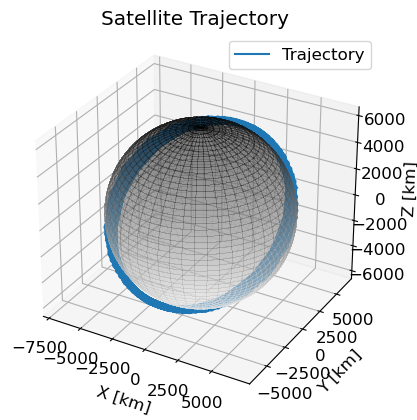

,Timestamp,Density (kg/m3)
0,2013-11-30 00:00:00+00:00,1.145228e-19
1,2013-11-30 00:10:00+00:00,6.537140e-20
2,2013-11-30 00:20:00+00:00,6.132228e-20
3,2013-11-30 00:30:00+00:00,1.570299e-19
4,2013-11-30 00:40:00+00:00,2.710546e-19
...,...,...
427,2013-12-02 23:10:00+00:00,5.273483e-20
428,2013-12-02 23:20:00+00:00,1.188559e-19
429,2013-12-02 23:30:00+00:00,2.481071e-19
430,2013-12-02 23:40:00+00:00,2.801259e-19


In [7]:
model = PersistenceModel(plot_trajectory=True)
predictions = model(omni2_data)
predictions

Last but not least, we save the "trained" model to the folder `/trained_model/`, from where we can retrieve it in the future when we want to execute it during our submission. We use `dill` to properly save all the dependencies of the model.


In [8]:
torch.save(model, './trained_model/persistence_model.pkl', pickle_module=dill)

# Submission Test

Here, you can also test the `submission.py` script to ensure it is working correctly. This script will inform the execution node on our servers about the entry point of your submission, so you need to implement all the logic on how to run the submission inside it. Be very careful when checking that this file works properly, and also test it by executing the Docker container using the instructions found in this baseline folder.

In this case, we will only execute it with a reduced amount of test files and initial states.


In [29]:
!python3 submission.py

Starting propagation...: 100%|████████████████| 431/431 [05:22<00:00,  1.34it/s]
Time interval [s]: 259200.0
Time step [s]: 600.0
CPU time [s]: 324.7751588821411
Final Pos [km]: 12751992.287141606
Final Vel [km]: 0.18804990973487995
Figure(640x480)
Model execution for wu001 Finished
Starting propagation...: 100%|████████████████| 431/431 [06:02<00:00,  1.19it/s]
Time interval [s]: 259200.0
Time step [s]: 600.0
CPU time [s]: 365.07708954811096
Final Pos [km]: 12762258.26327764
Final Vel [km]: 0.20677636439563604
Figure(640x480)
Model execution for wu002 Finished
Starting propagation...: 100%|████████████████| 431/431 [06:05<00:00,  1.18it/s]
Time interval [s]: 259200.0
Time step [s]: 600.0
CPU time [s]: 368.0975296497345
Final Pos [km]: 12751804.775140231
Final Vel [km]: 0.18123942644192156
Figure(640x480)
Model execution for wu003 Finished
Saved predictions to: submission/submission.json
